# 6. Pathway Enrichment of LR loadings

Cell-cell communication inference from single-cell data provides unprecedented insights into the molecular mechanisms underlying cell-cell communication. In particular, it enables the capture of CCC interactions at a systems level, which is not possible with traditional approaches. However, as the number of inferred interactions increases, the interpretation of the inferred cell-cell communication networks becomes more challenging. To this end, as done in other omics studies, we can perform pathway enrichment analysis to identify the general biological processes that are enriched in the inferred interactions. Pathway enrichment thus serves two purposes; it reduces the dimensionality of the inferred interactions, and also provides a biological summary of the inferred interactions.

In this tutorial, we will show how to use the `cell2cell` and `liana` packages to perform classical gene set enrichment analysis using `GSEA` with `KEGG Pathways`, and also we will use perform a footprint enrichment analysis using a `multi-variate linear regression` with the PROGENy pathway resource. We will use the [`GSEAPY`](https://gseapy.readthedocs.io/en/latest/) and [`decoupleR`](https://saezlab.github.io/decoupleR/) packages to perform these analyses.

In [1]:
library(liana, quietly = TRUE)

library(decoupleR, quietly = TRUE)
library(textshape, quietly = TRUE)
library(reshape2, quietly = TRUE)

library(tibble, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(tidyr, quietly = TRUE)
library(rstatix, quietly = TRUE)
library(ggpubr, quietly = TRUE)
library(forcats, quietly = T)

library(stringr, quietly = TRUE)

library(ggplot2, quietly = TRUE)

library(reticulate, quietly = TRUE)


Attaching package: ‘decoupleR’


The following objects are masked from ‘package:liana’:

    show_methods, show_resources



Attaching package: ‘tibble’


The following object is masked from ‘package:textshape’:

    column_to_rownames



Attaching package: ‘dplyr’


The following object is masked from ‘package:textshape’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [2]:
use_condaenv('ccc_protocols')
c2c <- reticulate::import(module = "cell2cell")

## Directories

In [3]:
output_folder <- file.path('..', '..', 'data', 'tc2c-outputs')
data_path <- file.path('..', '..', 'data')

## Load Data

**Open the loadings obtained from the tensor factorization**

In [4]:
covid_data <- readRDS(file.path(data_path, 'covid_data_sce.rds'))
factors <- liana::get_c2c_factors(sce = covid_data,
                                  sample_col = "sample_new",
                                  group_col = "condition")

**Load list of LR pairs used as reference to [run LIANA](./02-Infer-Communication-Scores.ipynb)**

In [5]:
lr_pairs <- liana::select_resource('Consensus')[[1]] %>%
    select(ligand = source_genesymbol, receptor = target_genesymbol)

**Generate a list with the LR pair names**

KEGG was originally designed to work with list of genes. Here we are using ligand-receptor pairs, so instead of using Gene Sets we need to build our LR-gene sets. This list is a first step to build the LR-gene sets.

In [6]:
lr_list <- lr_pairs %>%
     unite('interaction', ligand, receptor, sep = '^') %>% 
     pull(interaction)

## Gene Set Enrichment Analysis

In this case, we will run the PreRank method of GSEA since our LR pairs are pre-ranked based on their loadings in each factor obtained by Tensor-cell2cell.

### Generate LR-gene set for running GSEA

`cell2cell` includes some resources associated with the Gene sets employed in GSEA. It includes annotations of GO Terms (BP), KEGG, and Reactome, for human and mouse.

**First, specify which organism and annotation DB to use**

In [7]:
organism = 'human' # For the COVID-19 data analyzed with LIANA+Tensor-cell2cell
pathwaydb = 'KEGG' # KEGG Pathways

**Generate the LR-gene set that will be used for running GSEA**

In [8]:
lr_set <- c2c$external$generate_lr_geneset(lr_list = lr_list, 
                                           complex_sep='_', # Separation symbol of the genes in the protein complex
                                           lr_sep='^', # Separation symbol between a ligand and a receptor complex
                                           organism=organism,
                                           pathwaydb=pathwaydb,
                                           readable_name=TRUE
                                           )

### Extract LR loadings for each factor

In [9]:
lr_loadings = factors[['interactions']] %>% 
                column_to_rownames("lr")

### Run GSEA

This external function implemented in `cell2cell` builds upon the function `gseapy.prerank()`.

All outputs will be saved in the `output_folder`. Make sure that this path exist before running this function.

In [10]:
gsea_res <- c2c$external$run_gsea(loadings=lr_loadings, 
                                  lr_set=lr_set,
                                  output_folder=output_folder,
                                  weight=as.integer(1),
                                  min_size=as.integer(15),
                                  permutations=as.integer(999),
                                  processes=as.integer(6),
                                  random_state=as.integer(6),
                                  significance_threshold=as.numeric(0.05)
                                  )
names(gsea_res)<-c('pvals', 'scores', 'gsea_df')

### Visualization

We can use the `pvals` and `scores`outputs to visualize the results as a Dot Plot:

In [11]:
gsea.dotplot<-function(pval_df, score_df, significance = 0.05, font_size = 15){
    pval_df <- pval_df[apply(pval_df<significance,1,any), apply(pval_df<significance, 2, any)] %>% 
            mutate_all(function(x) -1*log10(x + 1e-9))
    score_df <- score_df[rownames(pval_df), colnames(pval_df)]
    pval_df <- pval_df %>%
                    tibble::rownames_to_column('Annotation')
    score_df <- score_df %>%
                    tibble::rownames_to_column('Annotation')

    viz_df <- cbind(melt(pval_df), melt(score_df)[[3]])
    names(viz_df) <- c('Annotation', 'Factor', 'Significance', 'NES')
    
                       
    dotplot <- ggplot(viz_df, aes(x = Factor, y = Annotation)) + geom_point(aes(size = Significance, color = NES)) + 
                scale_color_gradient2() + theme_bw(base_size = font_size) + 
                theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))+
                       scale_size(range = c(0, 8)) + 
                       guides(size=guide_legend(title="-log10(p-value)"))
    return(dotplot)
}


Using Annotation as id variables

Using Annotation as id variables



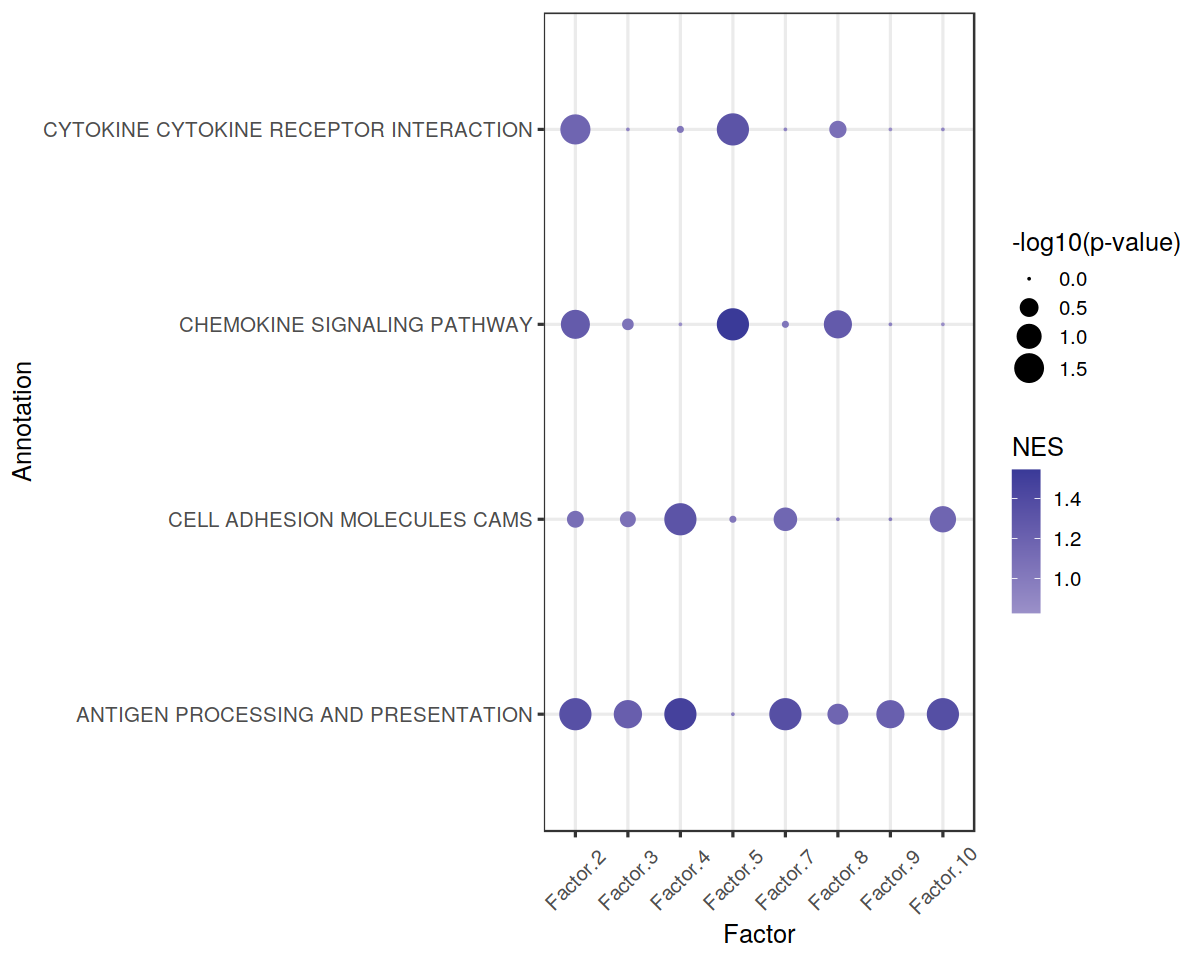

In [12]:
h_ = 8
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

dotplot <- gsea.dotplot(pval_df = gsea_res$pvals, 
                       score_df = gsea_res$scores, 
                       significance = 0.05)
dotplot

**Similarly, we can use gsea_df to easily see the Enriched Pathways**

In [13]:
gsea_df <- gsea_res$gsea_df
gsea_df %>% 
    filter(`Adj. P-value` < 0.05 & NES > 0) %>%
    arrange(desc(abs(NES)))

,Factor,Term,NES,P-value,Adj. P-value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
39,Factor.5,CHEMOKINE SIGNALING PATHWAY,1.546410,0.001000000,0.01671429
26,Factor.4,ANTIGEN PROCESSING AND PRESENTATION,1.479729,0.001000000,0.01671429
104,Factor.10,ANTIGEN PROCESSING AND PRESENTATION,1.364778,0.001000000,0.01671429
65,Factor.7,ANTIGEN PROCESSING AND PRESENTATION,1.361635,0.001000000,0.01671429
0,Factor.2,ANTIGEN PROCESSING AND PRESENTATION,1.356075,0.001000000,0.01671429
40,Factor.5,CYTOKINE CYTOKINE RECEPTOR INTERACTION,1.319706,0.001000000,0.01671429
27,Factor.4,CELL ADHESION MOLECULES CAMS,1.317271,0.001000000,0.01671429
78,Factor.8,CHEMOKINE SIGNALING PATHWAY,1.265677,0.005005005,0.04879880
1,Factor.2,CHEMOKINE SIGNALING PATHWAY,1.257363,0.003003003,0.03903904


**And Depleted Pathways**

In [14]:
gsea_df %>% 
    filter(`Adj. P-value` < 0.05 & NES < 0) %>%
    arrange(desc(abs(NES)))

Factor,Term,NES,P-value,Adj. P-value
<chr>,<chr>,<dbl>,<dbl>,<dbl>


## Footprint Enrichment

Footprint enrichment analysis build upon classic geneset enrichment analysis, as instead of considering the genes involved in a biological activity, they consider the genes affected by the activity, or in other words the genes that change downstream of said activity [(Dugourd and Saez-Rodriguez, 2019)](https://www.sciencedirect.com/science/article/pii/S2452310019300149). This is particularly useful when working with transcriptomics data, as it allows to identify the genes that are regulated by a biological process, instead of the genes that are part of the process. In this case, we will use the PROGENy pathway resource to perform footprint enrichment analysis. PROGENy was built in a data-driven manner using perturbation and cancer lineage data [(Schubert et al, 2019)](https://www.nature.com/articles/s41467-017-02391-6#Sec8), as a consequence it also assigns different importances or weights to each gene in its pathway genesets.

To this end, we need an enrichment method that can take weights into account, and here we will use multi-variate linear models from the `decoupleR` package to perform this analysis [(Badia-i-Mompel et al., 2022)](https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613).

###  load the PROGENy pathway resource:

In [15]:
# obtain progeny gene sets
net <- decoupleR::get_progeny(organism = 'human', top=5000) %>%
    dplyr::select(-p_value)

Now we will use the PROGENy genesets to assign pathways and weights to the ligand-receptor pairs in liana's consensus resource. Specifically, we will use the weighted bipartite networks from PROGENy, where the weight represents the importance of the genes to a given geneset, and assign a weight to each ligand-receptor interaction, based on the mean of the weights of the proteins in that ligand-receptor interaction. We keep only ligand-receptor weights only if all the protein in the ligand-receptor interaction are present for a given pathway, and are sign-coherent.

In [16]:
# convert to LR sets
progeny_lr <- liana::generate_lr_geneset(sce = covid_data,
                                          resource = net)
head(progeny_lr)

lr,set,mor
<chr>,<chr>,<dbl>
ACTR2^LDLR,EGFR,1.1326914
ADAM10^CADM1,MAPK,-1.0350601
ADAM10^GPNMB,EGFR,-1.9858320
ADAM10^GPNMB,MAPK,-2.7904170
ADAM10^NOTCH1,EGFR,-0.9249343
ADAM10^NOTCH1,MAPK,-0.9250379


### Run footprint enrichment analysis

We will now use the `decoupleR` package to perform the analysis.

In [17]:
# interaction loadings to matrix
mat <- factors$interactions %>%
    textshape::column_to_rownames("lr") %>%
  as.matrix()

# run enrichment analysis with decoupler
# (we fit a univariate linear model for each gene set)
# We don't consider genesets with minsize < 10
res <- decoupleR::run_ulm(mat = mat,
                          network = progeny_lr,
                          .source = "set",
                          .target = "lr",
                          minsize=10) %>%
  mutate(p_adj = p.adjust(p_value, method = "fdr"))

### Visualize Results

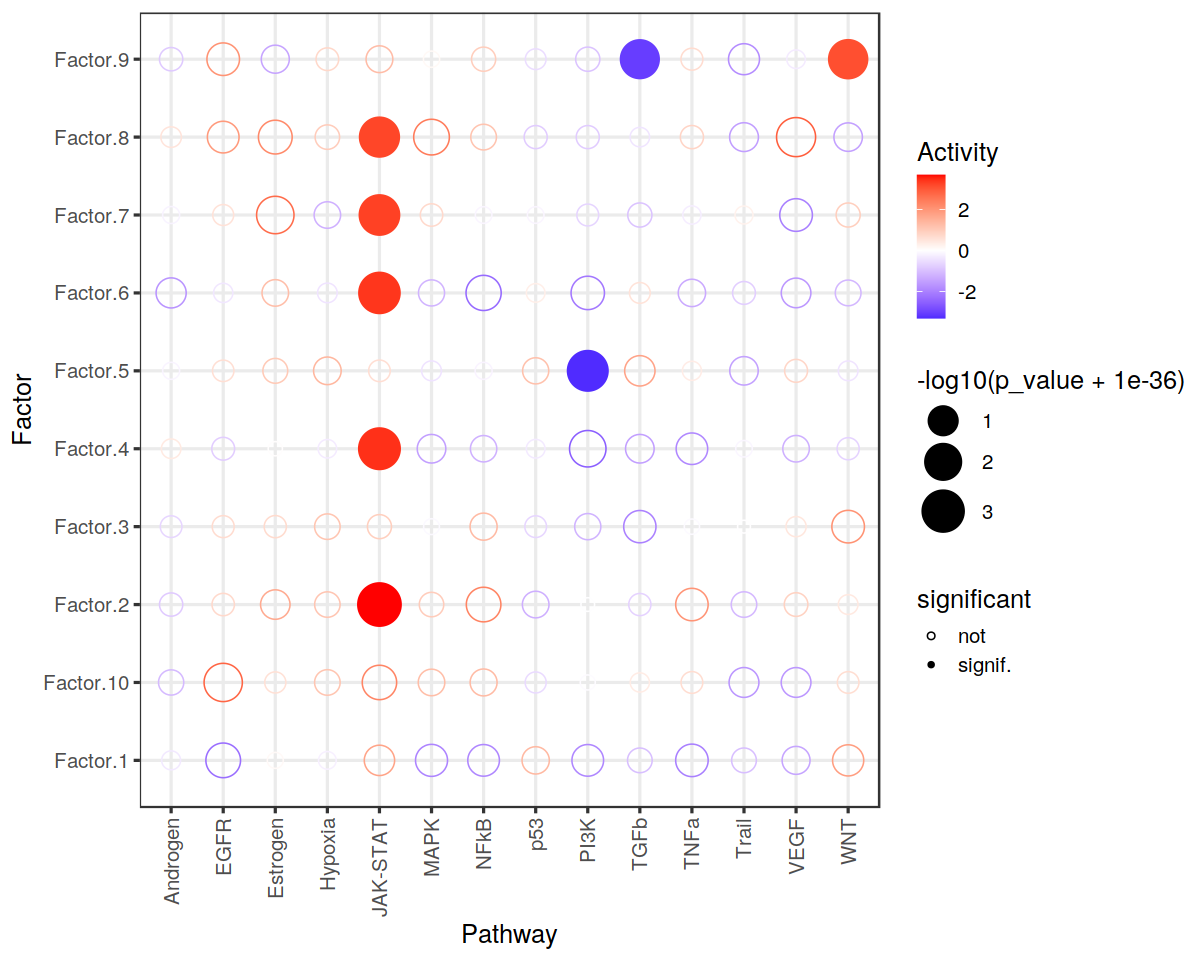

In [18]:
res %>% # sig/isnig flag
  mutate(significant = if_else(p_adj <= 0.05, "signif.", "not")) %>%
  ggplot(aes(x=source, y=condition, shape=significant,
             colour=score, size=-log10(p_value+1e-36))) +
  geom_point() +
  scale_colour_gradient2(high = "red", low="blue") +
  scale_size_continuous(range = c(3, 12)) +
  scale_shape_manual(values=c(21, 16)) +
  theme_bw(base_size = 15) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  labs(x="Pathway",
       y="Factor",
       colour="Activity"
       )

Let's zoom in on **Factor 2**, which is associated with COVID-19 cases.

In [19]:
selected_factor = 'Factor.2'

In [20]:
sample_loadings <- liana::get_c2c_factors(covid_data,
                                          sample_col='sample_new',
                                          group_col='condition') %>%
                                          purrr::pluck("contexts") %>% 
                                          pivot_longer(-c("condition", "context"),
                                                names_to = "factor",
                                                values_to = "loadings") %>% 
                                          mutate(factor = factor(factor)) %>%
                                          mutate(factor = forcats::fct_relevel(factor, "Factor.10", after=9))

In [21]:
res.factor <- res %>% 
                filter(condition == selected_factor) %>%
                mutate(p_adj = p.adjust(p_value, method = "fdr")) %>%
                arrange(desc(score)) %>%
                mutate(source = factor(source, levels = source))

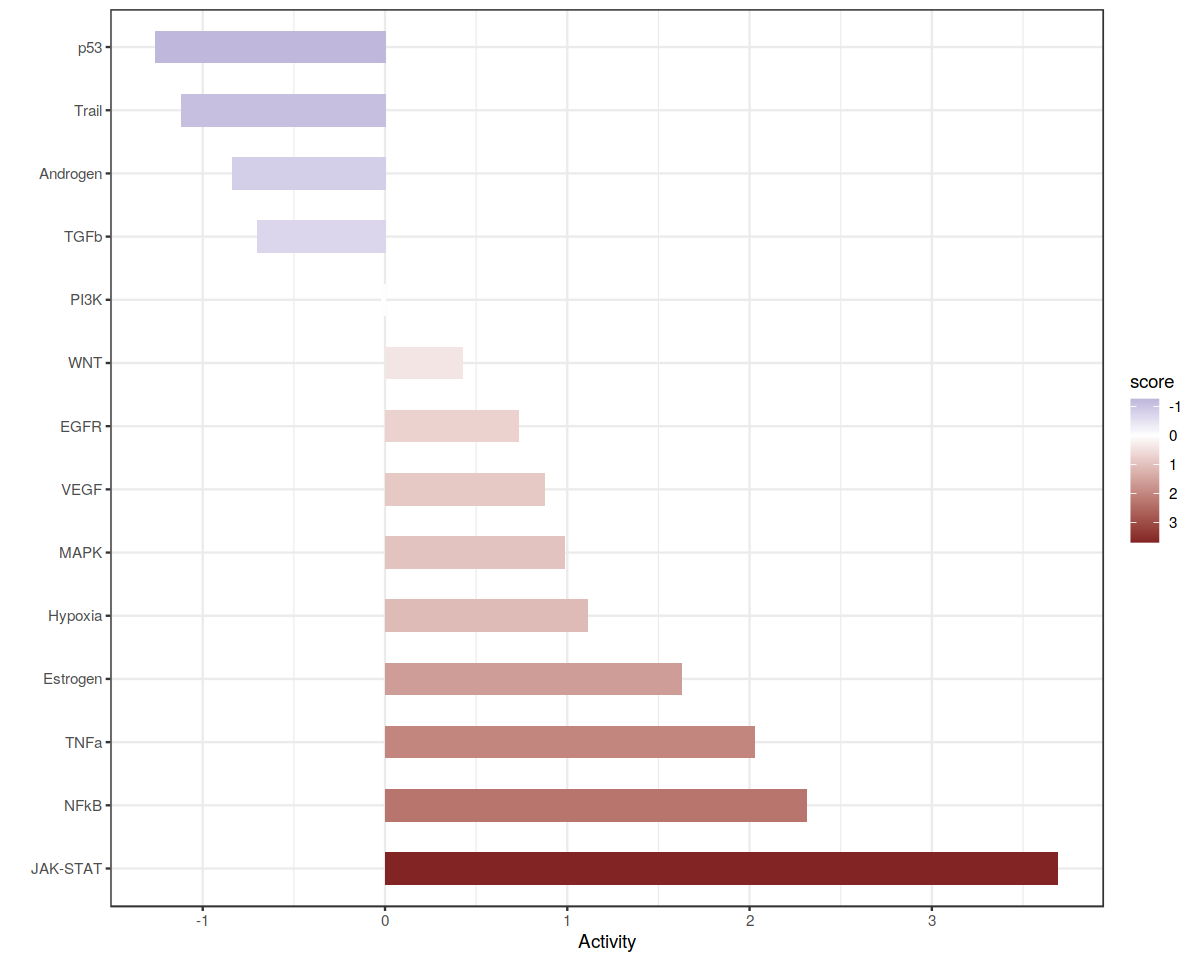

In [22]:
ggplot(data=res.factor, aes(x=score, y=source, fill = score)) +
  geom_bar(stat="identity", width=0.5) + theme_bw() + scale_fill_gradient2(trans = 'reverse') + 
ylab('') + xlab('Activity')

From the plots above, we can see that the **JAK-STAT** pathway is downregulated in **Factor 2**. Let's see which ligand-receptor pairs are enriched in this pathway.

In [23]:
selected_pathway = 'JAK-STAT'

# loadings to long format
lrs <-  factors$interactions %>%
  inner_join(progeny_lr, by="lr") %>%
  filter(set==selected_pathway) %>%
  select(lr, set, mor, loading = !!selected_factor) %>%
  mutate(lr = gsub(as.character(str_glue("\\^")), " -> ", lr)) %>%
  mutate(weight = if_else(mor >= 0, "positive", "negative"))

head(lrs)

lr,set,mor,loading,weight
<chr>,<chr>,<dbl>,<dbl>,<chr>
B2M -> LILRB2,JAK-STAT,1.4282332,0.0626261234,positive
CCL18 -> CCR1,JAK-STAT,1.0966844,0.0064965924,positive
CCL2 -> CCR1,JAK-STAT,2.1039209,0.0956255049,positive
CCL7 -> CCR1,JAK-STAT,1.1451122,0.0240483209,positive
CCL7 -> CXCR3,JAK-STAT,0.6823783,0.0006287554,positive
CCL8 -> CCR1,JAK-STAT,3.5262996,0.0672065616,positive


##### plot the loadings for that Factor and the weights of the pathway

`geom_smooth()` using formula 'y ~ x'

Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


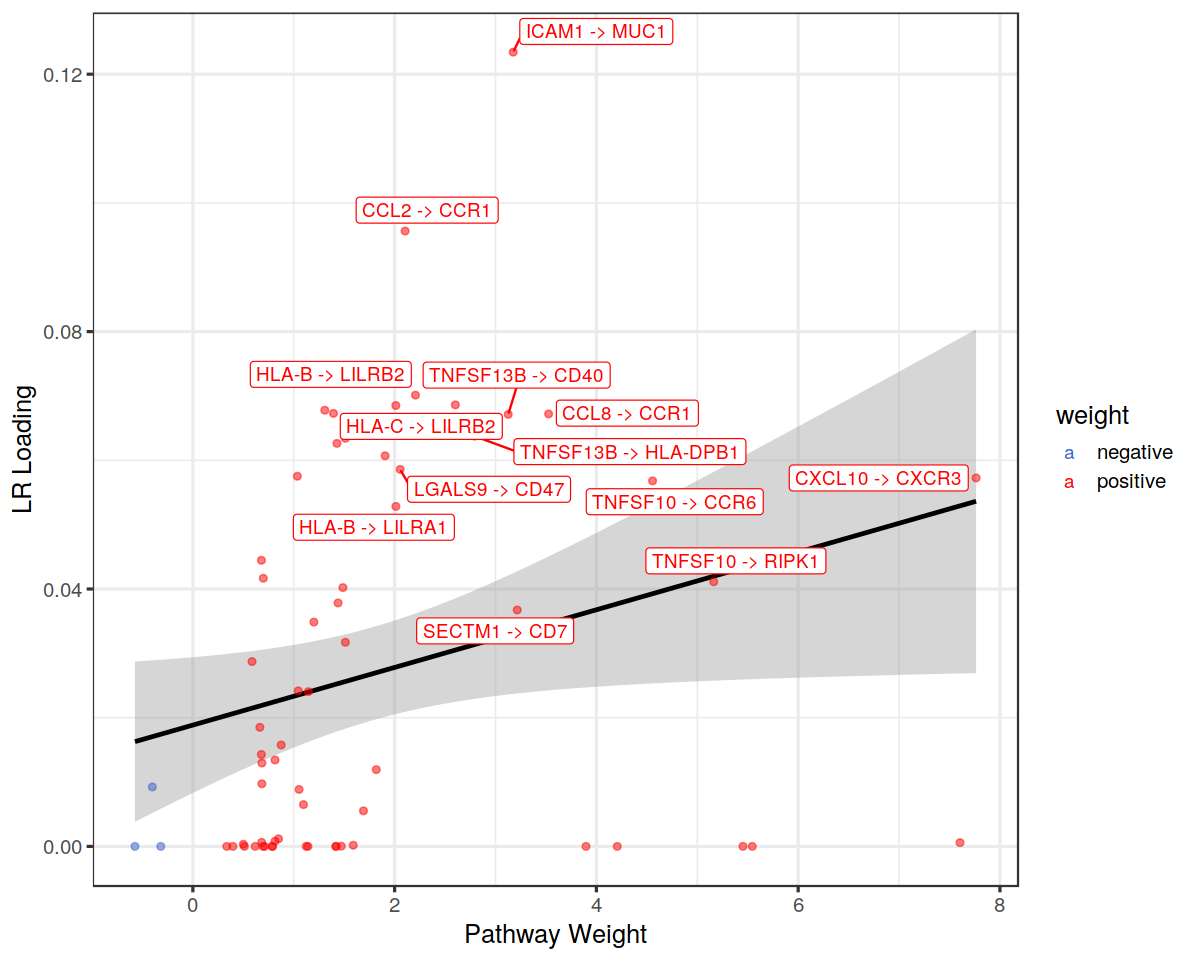

In [25]:
# Plot LRs associated the pathway
lrs %>%
  # only label those that are > x
  mutate(lr = if_else(loading>=0.001 & abs(mor) > 2, lr, "")) %>%
  ggplot(aes(x=mor, y=loading, colour=weight)) +
  # label only top 20
  stat_smooth(method = "lm", col = "black") +
  geom_point(alpha = 0.5) + 
  ggrepel::geom_label_repel(aes(label = lr)) +
  theme_bw(base_size = 15) +
  scale_colour_manual(values = c("royalblue3", "red")) +
  labs(x="Pathway Weight", y="LR Loading")